In [1]:
# Gradient descent vs. ascent
# Initialization strategies?
# Linear programming problem
# Removed action completely from the network in Linear. I think we can't do this completely for q-value fn. 
# Ask Barbara what class of fns for Q-value
# Simulated openai environments, contrastive NN, non-linear, normalization

In [2]:
import json
import sys
sys.path.append('../simulated_fqi/')
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import torch
import random
import shap
import configargparse
import torch
import torch.optim as optim

from environments import Gridworld
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
from train import fqi
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.linear_model import LinearRegression
from irl_gridworld import find_feature_expectations, plot_reward, norm, find_valid_actions, generate_rollout, generate_policy_rollout, runLinearFQI, l2_norm

# FQI with Neural Network
* It doesn't learn true reward
* It only predicts left or up
* Gradients for fg and shared are the same. This doesn't make sense.

In [ ]:
def runFQI(verbose=True, epoch=100, init_experience=100, evaluations=5, reward_weights_shared=np.asarray([3, 3]),
          reward_weights_fg = np.asarray([-6, 0]), run_fg=True, run_bg=True):
    # Setup environment
    if run_bg:
        train_env_bg = Gridworld(group=0, shared_weights=reward_weights_shared, target_state=[3, 3])
        eval_env_bg = Gridworld(group=0, shared_weights=reward_weights_shared, target_state=[3, 3])
    if run_fg:
        train_env_fg = Gridworld(group=1, shared_weights=reward_weights_shared, fg_weights=reward_weights_fg, target_state=[0, 3])
        eval_env_fg = Gridworld(group=1, shared_weights=reward_weights_shared, fg_weights=reward_weights_fg, target_state=[0, 3])
    
    # NFQ Main loop
    bg_rollouts = []
    fg_rollouts = []
    if init_experience > 0:
        for _ in range(init_experience):
            if run_bg:
                rollout_bg, episode_cost = train_env_bg.generate_rollout(None, render=False, group=0)
                bg_rollouts.extend(rollout_bg)
            if run_fg:
                rollout_fg, episode_cost = train_env_fg.generate_rollout(None, render=False, group=1)
                fg_rollouts.extend(rollout_fg)
    if run_bg:
        all_rollouts = bg_rollouts
    if run_fg:
        all_rollouts = fg_rollouts
    if run_bg and run_fg:
        bg_rollouts.extend(fg_rollouts)
        all_rollouts = bg_rollouts.copy()

    bg_rollouts_test = []
    fg_rollouts_test = []
    if init_experience > 0:
        for _ in range(init_experience):
            if run_bg:
                rollout_bg, episode_cost = eval_env_bg.generate_rollout(None, render=False, group=0)
                bg_rollouts_test.extend(rollout_bg)
            if run_fg:
                rollout_fg, episode_cost = eval_env_fg.generate_rollout(None, render=False, group=1)
                fg_rollouts_test.extend(rollout_fg)
    if run_bg:
        all_rollouts_test = bg_rollouts_test
    if run_fg:
        all_rollouts_test = fg_rollouts_test
    if run_bg and run_fg:
        bg_rollouts_test.extend(fg_rollouts)
        all_rollouts_test = bg_rollouts_test.copy()
    
    # Setup agent
    nfq_net = ContrastiveNFQNetwork(state_dim=2, is_contrastive=False)

    optimizer = optim.Adam(nfq_net.parameters(), lr=1e-1)
    nfq_agent = NFQAgent(nfq_net, optimizer)

    bg_success_queue = [0] * 3
    fg_success_queue = [0] * 3
    epochs_fg = 0
    eval_fg = 0
    for k, epoch in enumerate(tqdm.tqdm(range(epoch + 1))):
        state_b, target_q_values, groups = nfq_agent.generate_pattern_set(
            all_rollouts, reward_weights_shared=reward_weights_shared, reward_weights_fg=reward_weights_fg, use_weights=False
        )
        
        if not nfq_net.freeze_shared:
            loss = nfq_agent.train((state_b, target_q_values, groups))

        eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = 0, 0, 0
        if nfq_net.freeze_shared:
            eval_fg += 1
            if eval_fg > 50:
                loss = nfq_agent.train((state_action_b, target_q_values, groups))
        if run_bg:
            (eval_episode_length_bg,eval_success_bg,eval_episode_cost_bg) = nfq_agent.evaluate(eval_env_bg, render=False)
        if run_fg:
            (eval_episode_length_fg,eval_success_fg,eval_episode_cost_fg) = nfq_agent.evaluate(eval_env_fg, render=False)
        
        if run_bg:
            bg_success_queue = bg_success_queue[1:]
            bg_success_queue.append(1 if eval_success_bg else 0)
        if run_fg:
            fg_success_queue = fg_success_queue[1:]
            fg_success_queue.append(1 if eval_success_fg else 0)

        printed_bg = False
        printed_fg = False

        if sum(bg_success_queue) == 3 and not nfq_net.freeze_shared == True:
            if epochs_fg == 0:
                epochs_fg = epoch
            printed_bg = True
            nfq_net.freeze_shared = True
            if verbose:
                print("FREEZING SHARED")
                if not run_fg:
                    break
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = False

            optimizer = optim.Adam(
                itertools.chain(
                    nfq_net.layers_fg.parameters(),
                    nfq_net.layers_last_fg.parameters(),
                ),
                lr=1e-1,
            )
            nfq_agent._optimizer = optimizer
        if run_fg:
            if sum(fg_success_queue) == 3:
                printed_fg = True
                break

    for k in range(evaluations):
        if run_bg:
            (eval_episode_length_bg,eval_success_bg,eval_episode_cost_bg) = nfq_agent.evaluate(eval_env_bg, False)
            if verbose:
                print("Success: ", eval_success_bg)
            train_env_bg.close()
            eval_env_bg.close()
        if run_fg:
            (eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg) = nfq_agent.evaluate(eval_env_fg, False)
            if verbose:
                print("Success: ", eval_success_fg)
            train_env_fg.close()
            eval_env_fg.close()
    if run_fg:
        print("Fg trained after " + str(epochs_fg) + " epochs")
    
    print("Generating policy rollout")
    bg_rollouts = []
    fg_rollouts = []
    if init_experience > 0:
        for _, _ in enumerate(tqdm.tqdm(range(int(init_experience/2)))):
            if run_bg:
                rollout_bg, episode_cost = train_env_bg.generate_rollout(
                    nfq_agent, render=False, group=0, random_start = False
                )
                bg_rollouts.extend(rollout_bg)
            if run_fg:
                rollout_fg, episode_cost = train_env_fg.generate_rollout(
                    nfq_agent, render=False, group=1, random_start = False
                )
                fg_rollouts.extend(rollout_fg)
    
    if run_bg:
        policy_rollouts = bg_rollouts
    if run_fg:
        policy_rollouts = fg_rollouts
    if run_bg and run_bg:
        bg_rollouts.extend(fg_rollouts)
        policy_rollouts = bg_rollouts.copy()
    
    return policy_rollouts, nfq_agent

In [ ]:
epochs=200; learning_rate=0.2; init_w_shared = [0.5]*2; init_w_fg = [0.5]*2
w_shared = init_w_shared
w_fg = init_w_fg

muB_shared = None
muB_fg = None

diff_shared = []
diff_fg = []

true_weights_bg = [0.5, 0.5]
true_weights_fg = [-2., 0.5]
print("Generating optimal behavior")
behavior_rollout_bg, opt_agent_bg = runFQI(run_fg=False, run_bg=True, reward_weights_shared=true_weights_bg)
behavior_rollout_fg, opt_agent_fg = runFQI(run_fg=True, run_bg=False, reward_weights_shared=true_weights_bg, reward_weights_fg=true_weights_fg)

muB_shared = find_feature_expectations(behavior_rollout_bg, shared=True)
muB_fg = find_feature_expectations(behavior_rollout_fg, shared=False)

for i in range(epochs):
    print('Epoch', i, '- Train pi with current w_shared='+str(w_shared) + " w_fg=", w_fg )
    policy_rollout_bg, agent_pi_bg = runFQI(run_fg=False, run_bg=True, reward_weights_shared=w_shared, reward_weights_fg=None)
    policy_rollout_fg, agent_pi_fg = runFQI(run_fg=True, run_bg=False, reward_weights_shared=w_shared, reward_weights_fg=w_fg)

    #print('Evaluate feature expectations for pi')
    # Generate rollout with this policy, thens do feature expectations
    mu_shared = find_feature_expectations(policy_rollout_bg, shared=True)
    mu_fg = find_feature_expectations(policy_rollout_fg, shared=False)
    print("Shared feature expectations: ", mu_shared)
    print("Fg feature expectations: ", mu_fg)

    #print('Gradient update for new w')
    grad_shared = norm(muB_shared) - norm(mu_shared) + norm(muB_fg) - norm(mu_fg)
    grad_fg = norm(muB_fg) - norm(mu_fg)
    print("Grad shared: " + str(grad_shared) + " Grad fg: " + str(grad_fg))

    w_shared_old = w_shared
    # w_shared += learning_rate*(0.95**i) * grad_shared
    w_shared += learning_rate * grad_shared
    w_shared = w_shared/np.sum(np.abs(w_shared))

    w_fg_old = w_fg
    # w_fg += learning_rate*(0.95**i) * grad_fg
    w_fg += learning_rate * grad_fg
    w_fg = w_fg/np.sum(np.abs(w_fg))

    # Plot difference in feature expectations vs. weight values
    # Axes are weight values and each tile is difference in feature expectations from behavior
    # Lowest for weights that we want
    diff_shared.append(mean_absolute_error(w_shared_old, w_shared))
    diff_fg.append(mean_absolute_error(w_fg_old, w_fg))

plt.plot(diff_shared)
plt.plot(diff_fg)

# FQI with linear Q-value function
* Doesn't approximate target Q-values like the NFQ Net does
* But it can learn a linear reward function, as expected
* The policy rollouts are also pretty successful
* Need to generate separate policies to approximate different rewards

In [ ]:
epochs=200; learning_rate=1.; init_w_shared = [0.5]*2; init_w_fg = [0.5]*2
w_shared = init_w_shared
w_fg = init_w_fg

muB_shared = None
muB_fg = None

diff_shared = []
diff_fg = []

true_weights_bg = [0.5, 0.5]
true_weights_fg = [-1., 0]
print("Generating behavior with true weights shared=" + str(true_weights_bg) + " true_weights_fg=" + str(true_weights_fg))
behavior_rollout_bg, opt_agent_bg = runLinearFQI(dataset='bg', reward_weights_shared=true_weights_bg, behavior=True)
behavior_rollout_fg, opt_agent_fg = runLinearFQI(dataset='fg', reward_weights_shared=true_weights_bg, reward_weights_fg=true_weights_fg, behavior=True)

muB_shared = find_feature_expectations(behavior_rollout_bg, shared=True)
muB_fg = find_feature_expectations(behavior_rollout_fg, shared=False, g=1)

for i in range(epochs):
    print('Epoch', i, '- Train pi with current w_shared='+str(w_shared) + " w_fg=", w_fg )
    policy_rollout_bg, agent_pi_bg = runLinearFQI(reward_weights_shared=w_shared, reward_weights_fg=None, dataset='bg')
    policy_rollout_fg, agent_pi_fg = runLinearFQI(reward_weights_shared=w_shared, reward_weights_fg=w_fg, dataset='fg')

    #print('Evaluate feature expectations for pi')
    # Generate rollout with this policy, then do feature expectations
    mu_shared = find_feature_expectations(policy_rollout_bg, shared=True)
    mu_fg = find_feature_expectations(policy_rollout_fg, shared=False, g=1)
    print("Shared feature expectations: ", mu_shared)
    print("Fg feature expectations: ", mu_fg)

    #print('Gradient update for new w')
    grad_shared = norm(muB_shared) - norm(mu_shared) + norm(muB_fg) - norm(mu_fg)
    grad_fg = norm(muB_fg) - norm(mu_fg)
    print("Grad shared: " + str(grad_shared) + " Grad fg: " + str(grad_fg))

    w_shared_old = w_shared
    # w_shared += learning_rate*(0.95**i) * grad_shared
    w_shared += learning_rate * grad_shared
    w_shared = w_shared/np.sum(np.abs(w_shared))

    w_fg_old = w_fg
    # w_fg += learning_rate*(0.95**i) * grad_fg
    w_fg += learning_rate * grad_fg
    # Don't normalize here: Normalizing here doesn't really matter
    w_fg = w_fg/np.sum(np.abs(w_fg))

    diff_shared.append(mean_absolute_error(w_shared_old, w_shared))
    diff_fg.append(mean_absolute_error(w_fg_old, w_fg))

plt.plot(diff_shared)
plt.plot(diff_fg)

In [ ]:
#boxplot, 4boxes (2 for each weights), fg --> plot sum, draw from gaussian (mean 0)

In [ ]:
def plot_reward(n=4, title='Shared True Reward', reward_weights_shared=None, reward_weights_fg=None, agent=None, file=None):
    reward_matrix = np.zeros((n, n))
    positions = [i for i in range(n)]
    for i, x in enumerate(range(n)):
        for j, y in enumerate(range(n)):
            if reward_weights_shared is not None and reward_weights_fg is not None:
                reward = np.dot([x, y], np.add(reward_weights_shared, reward_weights_fg))
            elif reward_weights_shared is not None:
                reward = np.dot([x, y], reward_weights_shared)
            elif agent is not None:
                reward = agent.predict([[x, y]])
            reward_matrix[j,i] = reward
    plt.figure(figsize=(14, 5))
    ax = sns.heatmap(reward_matrix, xticklabels=positions, yticklabels=positions)
    plt.xlabel("X")
    plt.ylabel("Y")
    ax.invert_yaxis()
    plt.title(title, fontsize=20)
    if file is not None:
        plt.savefig(file)

In [ ]:
print("True weights bg: " + str(true_weights_bg) + " Recovered weights bg: " + str(w_shared))
print("True weights fg: " + str(np.add(true_weights_bg,true_weights_fg)) + " Recovered weights fg: " + str(np.add(w_shared, w_fg)))

In [ ]:
plot_reward(title="Background true reward", reward_weights_shared=[0, 1], file='g1_true_reward.png')
plot_reward(title="Foreground true reward", reward_weights_shared=[0, 1], reward_weights_fg = [1, 1], file='g2_true_reward.png')

#plot_reward(title='Opt agent shared reward', agent=opt_agent_bg)
#plot_reward(title='Background reward predicted by CIRL', reward_weights_shared=w_shared, agent=None, file='g1_pred_reward.png')

In [ ]:
# plot_reward(title='Opt agent fg reward', agent=opt_agent_fg)
plot_reward(title='Foreground reward predicted by CIRL', reward_weights_shared=w_shared, reward_weights_fg=w_fg, agent=None, file='g2_pred_reward.png')

# Mapping out the space of losses

In [ ]:
def calculate_loss(muB_shared, muB_fg, weights_bg=None, weights_fg=None, true_weights_bg=[3, 3], true_weights_fg=[-6, 0], fg=True):
    if fg:
        policy_rollout_fg, agent_pi_fg = runLinearFQI(reward_weights_shared=weights_bg, reward_weights_fg=weights_fg, dataset='fg')
        mu_fg = find_feature_expectations(policy_rollout_fg, shared=False, g=1)
        diff = np.linalg.norm(muB_fg-mu_fg)
    else:
        policy_rollout_bg, agent_pi_bg = runLinearFQI(reward_weights_shared=weights_bg, reward_weights_fg=None, dataset='bg')
        mu_shared = find_feature_expectations(policy_rollout_bg, shared=True)
        diff = np.linalg.norm(muB_shared-mu_shared)

    return diff

In [ ]:
behavior_rollout_bg, opt_agent_bg = runLinearFQI(dataset='bg', reward_weights_shared=true_weights_bg, behavior=True)
behavior_rollout_fg, opt_agent_fg = runLinearFQI(dataset='fg', reward_weights_shared=true_weights_bg, reward_weights_fg=true_weights_fg, behavior=True)
muB_shared = find_feature_expectations(behavior_rollout_bg, shared=True)
muB_fg = find_feature_expectations(behavior_rollout_fg, shared=False, g=1) 

In [ ]:
diff_matrix_fg = np.zeros((15, 15))
positions = [i/100 for i in range(-300, 300, 40)]
for i, x in enumerate(positions):
    for j, y in enumerate(positions):
        diff_matrix_fg[j,i] = calculate_loss(muB_shared=muB_shared, muB_fg=muB_fg, weights_bg=[0.5, 0.5], weights_fg=[x, y], fg=True)


In [ ]:
diff_matrix_bg = np.zeros((15, 15))
positions = [i/100 for i in range(-300, 300, 40)]
for i, x in enumerate(positions):
    for j, y in enumerate(positions):
        diff_matrix_bg[j,i] = calculate_loss(muB_shared=muB_shared, muB_fg=muB_fg, weights_bg=[x, y], fg=False)

In [ ]:
plt.figure(figsize=(14, 5))
ax = sns.heatmap(diff_matrix_bg, xticklabels=positions, yticklabels=positions)
plt.xlabel("Bg Weight Elt 0")
plt.ylabel("Bg Weight Elt 1")
ax.invert_yaxis()
plt.title("Difference in feature expectations for background weights", fontsize=20)
plt.savefig("bg_loss.png")

In [ ]:
plt.figure(figsize=(14, 5))
ax = sns.heatmap(diff_matrix_fg, xticklabels=positions, yticklabels=positions)
plt.xlabel("FG Weight Elt 0")
plt.ylabel("FG Weight Elt 1")
ax.invert_yaxis()
plt.title("Difference in feature expectations for foreground weights", fontsize=20)
plt.savefig("fg_loss.png")

# Temporary Conclusions
* CIRL recovers the closest reward weights to the initialized weights that are consistent with the observations
* Dependent on initialization. We learn bg weights really well since the initialization basically gives it away. 
The fg weights are a little harder to learn, but we're pretty good

# Distribution of weights experiment

In [ ]:
def gridworld_irl(epochs=200, learning_rate=1., init_w_shared = [0.5]*2, init_w_fg = [0.5]*2, verbose=False):
    w_shared = init_w_shared
    w_fg = init_w_fg

    muB_shared = None
    muB_fg = None

    true_weights_bg = [0.5, 0.5]
    true_weights_fg = [-6., 0]
    if verbose:
        print("Generating behavior with true weights shared=" + str(true_weights_bg) + " true_weights_fg=" + str(true_weights_fg))
    behavior_rollout_bg, opt_agent_bg = runLinearFQI(dataset='bg', reward_weights_shared=true_weights_bg, behavior=True)
    behavior_rollout_fg, opt_agent_fg = runLinearFQI(dataset='fg', reward_weights_shared=true_weights_bg, reward_weights_fg=true_weights_fg, behavior=True)

    muB_shared = find_feature_expectations(behavior_rollout_bg, shared=True)
    muB_fg = find_feature_expectations(behavior_rollout_fg, shared=False)

    for i in range(epochs):
        if verbose:
            print('Epoch', i, '- Train pi with current w_shared='+str(w_shared) + " w_fg=", w_fg )
        policy_rollout_bg, agent_pi_bg = runLinearFQI(reward_weights_shared=w_shared, reward_weights_fg=None, dataset='bg')
        policy_rollout_fg, agent_pi_fg = runLinearFQI(reward_weights_shared=w_shared, reward_weights_fg=w_fg, dataset='fg')

        #print('Evaluate feature expectations for pi')
        # Generate rollout with this policy, then do feature expectations
        mu_shared = find_feature_expectations(policy_rollout_bg, shared=True)
        mu_fg = find_feature_expectations(policy_rollout_fg, shared=False)
        if verbose:
            print("Shared feature expectations: ", mu_shared)
            print("Fg feature expectations: ", mu_fg)

        #print('Gradient update for new w')
        grad_shared = norm(muB_shared) - norm(mu_shared) + norm(muB_fg) - norm(mu_fg)
        grad_fg = norm(muB_fg) - norm(mu_fg)
        if verbose:
            print("Grad shared: " + str(grad_shared) + " Grad fg: " + str(grad_fg))

        w_shared_old = w_shared
        # w_shared += learning_rate*(0.95**i) * grad_shared
        w_shared += learning_rate * grad_shared
        w_shared = w_shared/np.sum(np.abs(w_shared))

        w_fg_old = w_fg
        # w_fg += learning_rate*(0.95**i) * grad_fg
        w_fg += learning_rate * grad_fg
        # Don't normalize here: Normalizing here doesn't really matter
        w_fg = w_fg/np.sum(np.abs(w_fg))
    
    return norm(w_fg + w_shared), w_shared

In [ ]:
fg_one = []
fg_two = []
shared_one = []
shared_two = []
for _, i in enumerate(tqdm.tqdm(range(20))):
    w_shared = np.random.normal(size=2)
    w_fg = np.random.normal(size=2)
    
    w_shared = w_shared / norm(w_shared)
    w_fg = w_fg / norm(w_fg)
    
    learned_fg, learned_shared = gridworld_irl(init_w_shared=w_shared, init_w_fg=w_fg)
    
    fg_one.append(learned_fg[0])
    fg_two.append(learned_fg[1])
    shared_one.append(learned_shared[0])
    shared_two.append(learned_shared[1])
    print("learned fg: " + str(learned_fg) + " learned bg: " + str(learned_shared))

In [ ]:
import pandas as pd
d = {'Fg Weight 0': fg_one, 'Fg Weight 1': fg_two, 'Shared Weight 0': shared_one, 'Shared Weight 1': shared_two}
df = pd.DataFrame(data=d)
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title("Gridworld CIRL weight variation: original fg=[-6., 0], original shared=[0.5, 0.5]")
plt.show()

# Comparing CIRL to IRL for two groups and IRL for both groups combined
* IRL for two groups without the shared gradient performs just as well as CIRL...
* Adding in the prior distribution on Beta --> this forces the weights to be positive? 
* And do we also still need normalization? We still need normalization, otherwise the weights explode. 

In [4]:
# Initialize B ~ N(0, 1/lambda^2)
def cirl(true_weights_bg=[0., 1], true_weights_fg=[0.5, 0.5], verbose=False):
    epochs=1000; learning_rate=1.
    mu, sigma = 0, 0.5 
    init_w_shared = np.random.normal(mu, sigma, 2)
    init_w_shared = init_w_shared/np.sum(np.abs(init_w_shared))
    init_w_fg = np.random.normal(mu, sigma, 2)
    init_w_fg = init_w_fg/np.sum(np.abs(init_w_fg))
    
    lambd = 0.01
    w_shared = init_w_shared
    w_fg = init_w_fg

    muB_shared = None
    muB_fg = None

    diff_shared = []
    diff_fg = []
    
    # Demonstrations
    behavior_rollout_bg, opt_agent_bg = runLinearFQI(dataset='bg', reward_weights_shared=true_weights_bg, behavior=True)
    behavior_rollout_fg, opt_agent_fg = runLinearFQI(dataset='fg', reward_weights_shared=true_weights_bg, reward_weights_fg=true_weights_fg, behavior=True)
    
    # Demonstration feature expections
    muB_shared = find_feature_expectations(behavior_rollout_bg, shared=True)
    muB_fg = find_feature_expectations(behavior_rollout_fg, shared=False, g=1)

    for _, i in enumerate(tqdm.tqdm(range(epochs))):
        if verbose:
            print('Epoch', i, '- Train pi with current w_shared='+str(w_shared) + " w_fg=", w_fg )
        policy_rollout_bg, agent_pi_bg = runLinearFQI(reward_weights_shared=w_shared, reward_weights_fg=None, dataset='bg')
        policy_rollout_fg, agent_pi_fg = runLinearFQI(reward_weights_shared=w_shared, reward_weights_fg=w_fg, dataset='fg')

        mu_shared = find_feature_expectations(policy_rollout_bg, shared=True)
        mu_fg = find_feature_expectations(policy_rollout_fg, shared=False, g=1)
        
        # Also minimize the l2 norm of the current set of weights scaled by lambda --> variance of prior (0.01)
        grad_shared = norm(muB_shared) - norm(mu_shared) + norm(muB_fg) - norm(mu_fg) + lambd * l2_norm(mu_shared)
        grad_fg = norm(muB_fg) - norm(mu_fg) + lambd* l2_norm(mu_fg)

        w_shared_old = w_shared
        w_shared += learning_rate * grad_shared
        w_shared = w_shared/np.sum(np.abs(w_shared))

        w_fg_old = w_fg
        # w_fg += learning_rate*(0.95**i) * grad_fg
        w_fg += learning_rate * grad_fg
        w_fg = w_fg/np.sum(np.abs(w_fg))

        diff_shared.append(mean_absolute_error(w_shared_old, w_shared))
        diff_fg.append(mean_absolute_error(w_fg_old, w_fg))
    
    plot_reward(title='CIRL background predicted reward', reward_weights_shared=w_shared, agent=None, file='cirl_g1_pred_reward.png')
    plot_reward(title='CIRL foreground predicted reward', reward_weights_shared=w_shared, reward_weights_fg=w_fg, agent=None, file='cirl_g2_pred_reward.png')
    plt.plot(diff_shared)
    plt.plot(diff_fg)
    return w_shared, w_fg
    
def irl(true_weights_bg=[0.5, 0.5], true_weights_fg=[-1., 0]):
    epochs=200; learning_rate=1.; init_w_shared = [0.5]*2; init_w_fg = [0.5]*2
    w_bg = init_w_shared
    w_fg = init_w_fg

    muB_bg = None
    muB_fg = None


    print("Generating behavior with true weights bg=" + str(true_weights_bg) + " true_weights_fg=" + str(true_weights_fg))
    behavior_rollout_bg, opt_agent_bg = runLinearFQI(dataset='bg', reward_weights_shared=true_weights_bg, behavior=True)
    behavior_rollout_fg, opt_agent_fg = runLinearFQI(dataset='fg', reward_weights_shared=true_weights_bg, reward_weights_fg=true_weights_fg, behavior=True)

    muB_bg = find_feature_expectations(behavior_rollout_bg, shared=False, g=0)
    muB_fg = find_feature_expectations(behavior_rollout_fg, shared=False, g=1)

    for i in range(epochs):
        print('Epoch', i, '- Train pi with current w_bg='+str(w_bg) + " w_fg=", w_fg )
        policy_rollout_bg, agent_pi_bg = runLinearFQI(reward_weights_shared=w_bg, reward_weights_fg=None, dataset='bg')
        policy_rollout_fg, agent_pi_fg = runLinearFQI(reward_weights_shared=w_bg, reward_weights_fg=w_fg, dataset='fg')

        mu_bg = find_feature_expectations(policy_rollout_bg, shared=False, g=0)
        mu_fg = find_feature_expectations(policy_rollout_fg, shared=False, g=1)

        grad_bg = norm(muB_bg) - norm(mu_bg)
        grad_fg = norm(muB_fg) - norm(mu_fg)

        w_bg_old = w_bg
        w_bg += learning_rate * grad_bg
        w_bg = w_bg/np.sum(np.abs(w_bg))

        w_fg_old = w_fg
        # w_fg += learning_rate*(0.95**i) * grad_fg
        w_fg += learning_rate * grad_fg
        # Don't normalize here: Normalizing here doesn't really matter
        w_fg = w_fg/np.sum(np.abs(w_fg))

    
    plot_reward(title='CIRL background predicted reward', reward_weights_shared=w_bg, agent=None, file='irl_g1_pred_reward.png')
    plot_reward(title='CIRL foreground predicted reward', reward_weights_shared=w_bg, reward_weights_fg=w_fg, agent=None, file='irl_g2_pred_reward.png')


100%|██████████| 1000/1000 [02:24<00:00,  6.90it/s]


W shared:  [0.43312245 0.56687755]
W fg:  [-0.28083409  0.71916591]


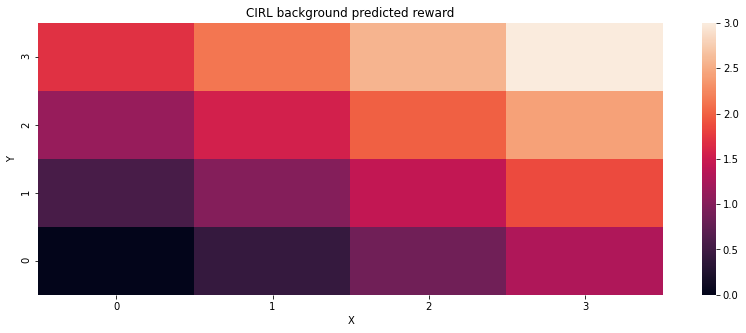

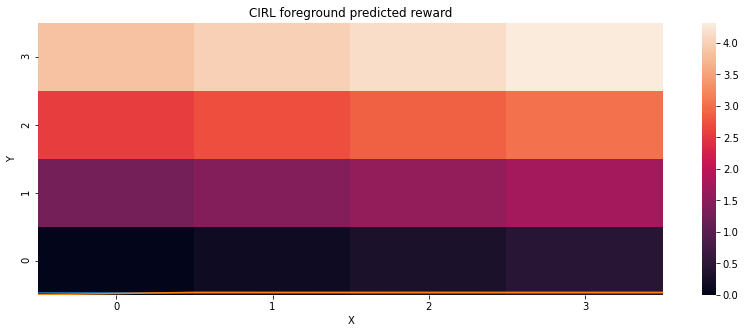

In [5]:
w_shared, w_fg = cirl()
print("W shared: ", w_shared)
print("W fg: ", w_fg)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [7]:
# Make the prior uniform so that MAP = MLE. 
# P(D | theta fg, theta bg) = norm(muB_shared) - norm(mu_shared) + norm(muB_fg) - norm(mu_fg)
# P(theta) = lambd * l2_norm(theta)

In [ ]:
# Metropolis Hasting
true_weights_bg=[0., 1]; true_weights_fg=[0.5, 0.5]

# Demonstrations
behavior_rollout_bg, opt_agent_bg = runLinearFQI(dataset='bg', reward_weights_shared=true_weights_bg, behavior=True)
behavior_rollout_fg, opt_agent_fg = runLinearFQI(dataset='fg', reward_weights_shared=true_weights_bg, reward_weights_fg=true_weights_fg, behavior=True)

# Demonstration feature expections
muB_shared = find_feature_expectations(behavior_rollout_bg, shared=True)
muB_fg = find_feature_expectations(behavior_rollout_fg, shared=False, g=1)

mu, sigma = 0, 0.5 
prev_w_shared = np.random.normal(mu, sigma, 2)
prev_w_shared = prev_w_shared/np.sum(np.abs(prev_w_shared))
prev_w_fg = np.random.normal(mu, sigma, 2)
prev_w_fg = prev_w_fg/np.sum(np.abs(prev_w_fg))

# Previous muFg, muShared
policy_rollout_bg, agent_pi_bg = runLinearFQI(reward_weights_shared=prev_w_shared, reward_weights_fg=None, dataset='bg')
policy_rollout_fg, agent_pi_fg = runLinearFQI(reward_weights_shared=prev_w_shared, reward_weights_fg=prev_w_fg, dataset='fg')

prev_mu_shared = find_feature_expectations(policy_rollout_bg, shared=True)
prev_mu_fg = find_feature_expectations(policy_rollout_fg, shared=False, g=1)

delta = 0.01
# Keep track of all of thetas, that's the full posterior

for i in range(1000):
    # g function is a gaussian with prev sample as mean
    new_w_shared_zero = np.random.normal(prev_w_shared[0], delta)
    new_w_shared_one = np.random.normal(prev_w_shared[1], delta)
    
    new_w_fg_zero = np.random.normal(prev_w_fg[0], delta)
    new_w_fg_one = np.random.normal(prev_w_fg[1], delta)
    
    new_w_shared = [new_w_shared_zero, new_w_shared_one]
    new_w_fg = [new_w_fg_zero, new_w_fg_one]
    
    # Forward RL with the new weights
    policy_rollout_bg, agent_pi_bg = runLinearFQI(reward_weights_shared=new_w_shared, reward_weights_fg=None, dataset='bg')
    policy_rollout_fg, agent_pi_fg = runLinearFQI(reward_weights_shared=new_w_shared, reward_weights_fg=new_w_fg, dataset='fg')
    
    # Calculate muFg and muShared
    mu_shared = find_feature_expectations(policy_rollout_bg, shared=True)
    mu_fg = find_feature_expectations(policy_rollout_fg, shared=False, g=1)
    
    # F : not true likelihood , gibbs posterior
    # e ^ -L(theta) * e^-l2 norm(theta)
    
    f_old = np.exp(norm(muB_shared) - norm(prev_mu_shared) + norm(muB_fg) - norm(prev_mu_fg))
    f_new = np.exp(norm(muB_shared) - norm(mu_shared) + norm(muB_fg) - norm(mu_fg))
    
    import ipdb; ipdb.set_trace()
    
    # Calculate which direction
    alpha = f_old/f_new
    
    # Calculate accept or pass on each element
    u = np.random.uniform((0, 1))
    if u < alpha[0]:
        # accept
        prev_w_shared_zero = new_w_shared[0]
        prev_w_shared_one = new_w_shared[1]
        prev_w_fg_zero = new_w_fg[0]
        prev_w
    
    else:
        # Don't accept
        pass

    

> <ipython-input-14-e3a4308e1060>(54)<module>()
     53     # Calculate which direction
---> 54     alpha = f_old/f_new
     55 

ipdb> muB_shared
array([1.83950617, 1.7962963 ])
ipdb> norm(muB_shared)
array([0.50594228, 0.49405772])
